In [1]:
import pandas as pd
from functools import partial
from torch.utils.data import Dataset, DataLoader

from scripts.dataset import MultimodalDataset, collate_fn, draw_item

сюда попал


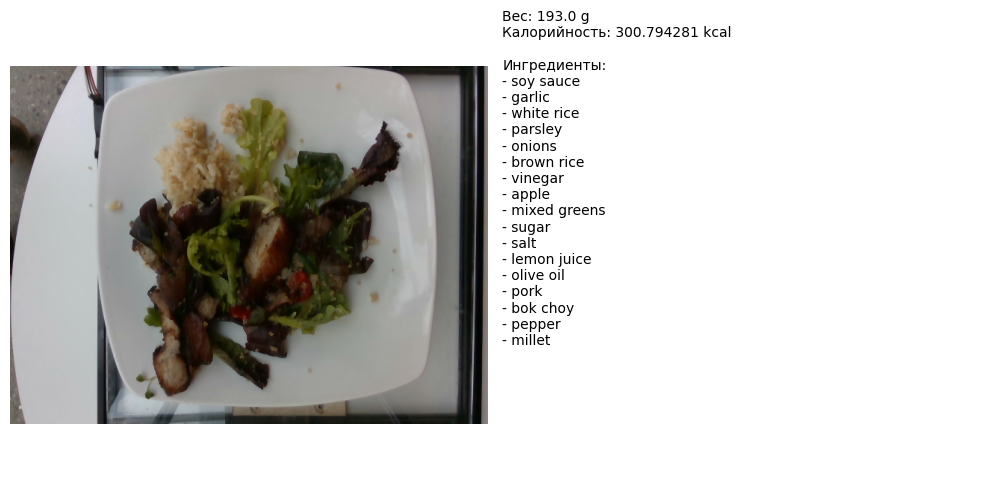

сюда попал


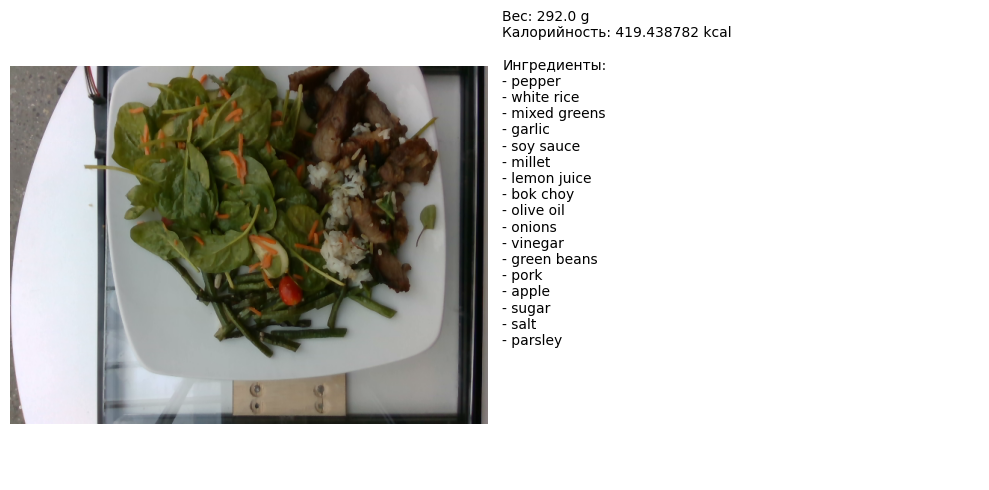

сюда попал


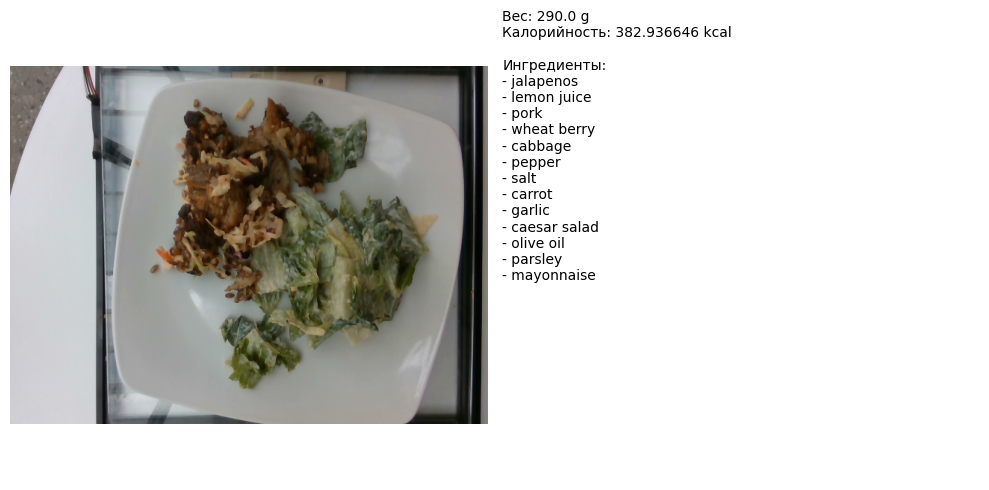

In [2]:
dish = pd.read_csv("data/dish.csv")
ingredients = pd.read_csv("data/ingredients.csv")

text_model = "bert-base-uncased"
image_model = 'tf_efficientnet_b0'

dataset = MultimodalDataset(
    dish,
    ingredients,
    text_model=text_model,
    image_model=image_model,
    transforms=None
)

loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=partial(collate_fn)
) 

for i in range(3):
    draw_item(dataset[i])
